In [1]:
import numpy as np

import os

from statsmodels.stats.api import DescrStatsW
from scipy.stats import ttest_rel, sem

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def labels_to_counts(labels, time_axis=0):
    onehot = np.zeros((labels.size, n_classes), dtype=int)
    onehot[np.arange(labels.size), labels] = 1
    
    return onehot.cumsum(axis=time_axis)


def log_utility(counts):
    return np.log(counts[:, 1:] + 1).sum(axis=1)


def linear_utility(counts):
    return counts[:, 1:].sum(axis=1)


data = 'morgan'

# group_size = 1
# num_exps = 120
# num_repeats_per_exp = 5

group_size = 3
num_exps = 20
num_repeats_per_exp = 1

policies = [
    'ens jensen greedy',
    'classical ens',
    'greedy',
    'round robin greedy',
]
if group_size == 1 and 'round robin greedy' in policies:
    policies.remove('round robin greedy')
    
utility_function = log_utility

n_classes = group_size + 1
init_size = 1
budget = 500

basepath = os.path.join('../../data/results', data)


utilities = np.ones(
    (len(policies), num_exps, num_repeats_per_exp, budget + init_size)
) * -1

for p_ind, policy in enumerate(policies):
    for exp_ind in range(num_exps):
        path = os.path.join(basepath, f'{data}{exp_ind + 1}', str(group_size), policy)
        for i in range(num_repeats_per_exp):
            labels = np.loadtxt(
                os.path.join(path, f'{policy}__labels__{i + 1}.csv'), 
                dtype=int
            ).flatten() - 1

            utilities[p_ind, exp_ind, i, :] = log_utility(labels_to_counts(labels))
        
assert np.all(utilities != -1)

In [3]:
utilities.shape

(4, 20, 1, 501)

In [4]:
utilities[..., -1].mean(axis=(1, 2))

array([9.48191929, 8.39533093, 7.97025885, 8.1810673 ])

ens jensen greedy: 9.4819
classical ens: 8.3953
greedy: 7.9703
round robin greedy: 8.1811


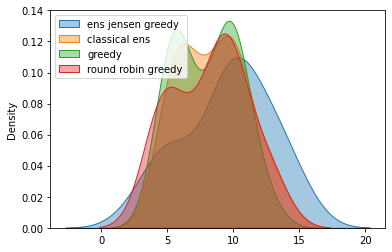

In [5]:
for p_ind, policy in enumerate(policies):
    print(f'{policy}: {utilities[p_ind, ..., -1].mean():.4f}')
    sns.kdeplot(utilities[p_ind, ..., -1].flatten(), alpha=0.4, shade=True, label=policy)
    
plt.legend(loc='upper left');

In [6]:
print(utilities.shape)
utilities

(4, 20, 1, 501)


array([[[[ 0.69314718,  0.69314718,  1.09861229, ..., 11.72584089,
          11.77029265, 11.81285226]],

        [[ 0.69314718,  0.69314718,  1.09861229, ..., 10.55846547,
          10.56382741, 10.56916076]],

        [[ 0.69314718,  1.09861229,  1.09861229, ..., 12.59076345,
          12.60259791, 12.61429395]],

        ...,

        [[ 0.69314718,  0.69314718,  0.69314718, ...,  2.7080502 ,
           2.77258872,  2.83321334]],

        [[ 0.69314718,  0.69314718,  1.09861229, ..., 10.63132597,
          10.63621596, 10.64112997]],

        [[ 0.69314718,  0.69314718,  1.09861229, ..., 14.33191101,
          14.33191101, 14.33994319]]],


       [[[ 0.69314718,  0.69314718,  1.09861229, ...,  5.42934563,
           5.42934563,  5.42934563]],

        [[ 0.69314718,  0.69314718,  1.09861229, ...,  8.51919119,
           8.52218073,  8.52218073]],

        [[ 0.69314718,  1.09861229,  1.09861229, ..., 13.07799134,
          13.07799134, 13.08868663]],

        ...,

        [[ 0.693

In [7]:
squeezed_utilities =  utilities.reshape(
    len(policies), 
    num_exps * num_repeats_per_exp, 
    budget + init_size
)

print(squeezed_utilities.shape)
squeezed_utilities

(4, 20, 501)


array([[[ 0.69314718,  0.69314718,  1.09861229, ..., 11.72584089,
         11.77029265, 11.81285226],
        [ 0.69314718,  0.69314718,  1.09861229, ..., 10.55846547,
         10.56382741, 10.56916076],
        [ 0.69314718,  1.09861229,  1.09861229, ..., 12.59076345,
         12.60259791, 12.61429395],
        ...,
        [ 0.69314718,  0.69314718,  0.69314718, ...,  2.7080502 ,
          2.77258872,  2.83321334],
        [ 0.69314718,  0.69314718,  1.09861229, ..., 10.63132597,
         10.63621596, 10.64112997],
        [ 0.69314718,  0.69314718,  1.09861229, ..., 14.33191101,
         14.33191101, 14.33994319]],

       [[ 0.69314718,  0.69314718,  1.09861229, ...,  5.42934563,
          5.42934563,  5.42934563],
        [ 0.69314718,  0.69314718,  1.09861229, ...,  8.51919119,
          8.52218073,  8.52218073],
        [ 0.69314718,  1.09861229,  1.09861229, ..., 13.07799134,
         13.07799134, 13.08868663],
        ...,
        [ 0.69314718,  0.69314718,  0.69314718, ...,  

In [8]:
for p1 in range(len(policies) - 1):
    for p2 in range(p1 + 1, len(policies)):
        if squeezed_utilities[p1, :, -1].mean() < squeezed_utilities[p2, :, -1].mean():
            alternative = "less"
        else:
            alternative = "greater"
        
        print(policies[p1], "vs.", policies[p2])
        print(
            ttest_rel(
                squeezed_utilities[p1, :, -1], 
                squeezed_utilities[p2, :, -1],
                alternative=alternative
            ).pvalue
        )
    print()

ens jensen greedy vs. classical ens
0.043854974912419936
ens jensen greedy vs. greedy
0.03393676369334394
ens jensen greedy vs. round robin greedy
0.06958071889532824

classical ens vs. greedy
0.20954585657554736
classical ens vs. round robin greedy
0.36636818555440265

greedy vs. round robin greedy
0.37277337241686265



7.90677832425159 11.05706025245929
0.7876
7.218149554585839 9.572512296972526
0.5886
6.8564987214518744 9.084018968560343
0.5569
6.881043974599795 9.481090620252726
0.6500


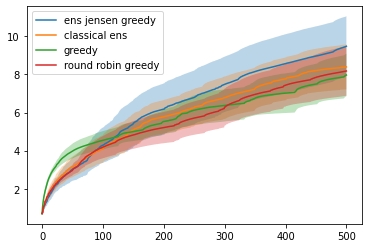

In [9]:
plt.figure()

for p_ind, policy in enumerate(policies):
    plt.plot(squeezed_utilities[p_ind].mean(axis=0), label=policy)
    lower, upper = DescrStatsW(squeezed_utilities[p_ind]).tconfint_mean()
    plt.fill_between(np.arange(init_size + budget), lower, upper, alpha=0.3)
    
    print(lower[-1], upper[-1])
    print(f'{(upper[-1] - lower[-1]) / 4:.4f}')
    
plt.legend();